## Computer Vision Knife Detection

In [2]:
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from os.path import isfile, isdir, getsize
from os import mkdir, makedirs, remove, listdir
from tqdm import tqdm

import zipfile
import tarfile
import imageio
import glob
import shutil
import pickle
import numpy as np

from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator

### Webcam Initialization

In [3]:
import cv2

camera = cv2.VideoCapture(0)

def get_image():
    re, im = camera.read()
    return im

### Dataset Initialization

In [4]:
datasetfolderpath = "/Users/kevin/desktop/Datas/knives"
files = glob.glob(datasetfolderpath + "/data/**/*.bmp")

labels = np.array([0]*3560 + [1]*9341)

In [5]:
len_data = len(files)
train_examples = 10000
test_examples = len_data - train_examples

permutation = np.random.permutation(len_data)
train_set = [files[i] for i in permutation[:train_examples]]
test_set = [files[i] for i in permutation[-test_examples:]]
train_labels = labels[permutation[:train_examples]]
test_labels = labels[permutation[-test_examples:]]

train_folder = datasetfolderpath + '/train'
test_folder = datasetfolderpath + '/test'

if isdir(train_folder):
    shutil.rmtree(train_folder)
if isdir(test_folder):
    shutil.rmtree(test_folder)
    
makedirs(train_folder + '/positive/')
makedirs(train_folder + '/negative/')
makedirs(test_folder + '/positive/')
makedirs(test_folder + '/negative/')

for f,i in zip(train_set, train_labels):
    if i == 0: 
        shutil.copy2(f, train_folder+'/positive/')
    else:
        shutil.copy2(f, train_folder+'/negative/')

for f,i in zip(test_set, test_labels):
    if i == 0: 
        shutil.copy2(f, test_folder+'/positive/')
    else:
        shutil.copy2(f, test_folder+'/negative/')

Found 10000 images belonging to 2 classes.


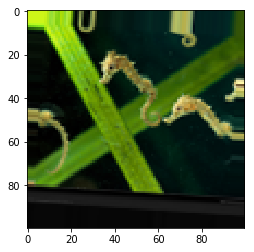

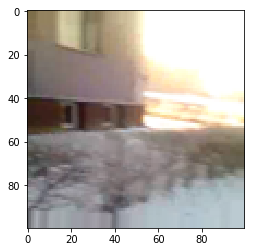

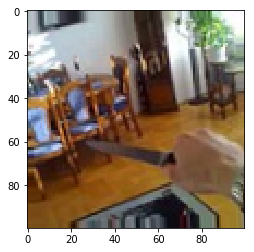

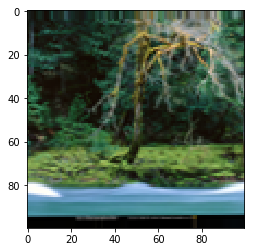

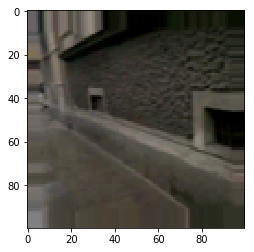

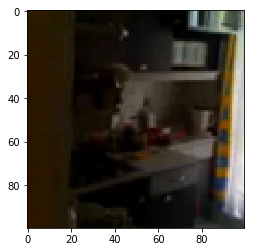

In [7]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 5,
    zoom_range = 0.2,
    horizontal_flip = True
)

img_height = img_width = 100

channels = 3
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = 'rgb',
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = None
)

i = 0
img_list = []

for batch in train_generator:
    img_list.append(batch)
    i += 1
    
    if i > 5:
        break

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()

### Logistic Regression

In [8]:
batch_size = 1000
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 10000 images belonging to 2 classes.


In [9]:
x_train, y_train = next(train_generator)
x_test, y_test = next(train_generator)

In [10]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(x_train.reshape(batch_size,-1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
y_pred = logistic.predict(x_test.reshape(len(x_test), -1))
y_pred[:10]

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0.], dtype=float32)

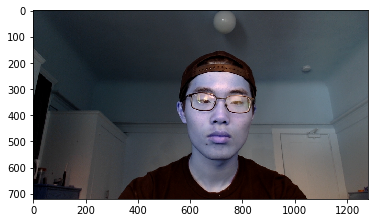

In [12]:
plt.imshow(get_image())
plt.show()

In [13]:
image = get_image()
cv2.imwrite('test.png', image)

True

In [14]:
from PIL import Image

img = Image.open('test.png')
input_shape = (3,3)

img_resized = img.resize(input_shape, Image.ANTIALIAS)
img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255

In [15]:
p = logistic.predict([img.reshape(-1)])
if p[0] == 0.00:
    print("This is a knife")
else:
    print("This is not a knife")

This is a knife


In [16]:
np.count_nonzero(y_pred == y_test) / len(y_test)

0.708

### Convolutional Neural Networks (CNN)

In [17]:
CNN_model = Sequential()

CNN_model.add(Conv2D(8, kernel_size=(3,3),padding='same',input_shape = (img_width, img_height, channels)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPool2D(pool_size=(3,3)))

CNN_model.add(Conv2D(16, kernel_size=(3,3),padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2)))

CNN_model.add(Conv2D(32, kernel_size=(3,3),padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2)))

CNN_model.add(Conv2D(32, kernel_size=(3,3),padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPool2D(pool_size=(2,2)))

CNN_model.add(Flatten())
CNN_model.add(Dense(1, activation='sigmoid'))
CNN_model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
__________

In [19]:
batch_size = 128
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')
history = CNN_model.fit_generator(train_generator, train_examples//batch_size, epochs=10)

Found 10000 images belonging to 2 classes.
Epoch 1/10
78/78 [==============================] - 144s 2s/step - loss: 0.4953 - acc: 0.7682
Epoch 2/10
78/78 [==============================] - 128s 2s/step - loss: 0.4041 - acc: 0.8122
Epoch 3/10
78/78 [==============================] - 150s 2s/step - loss: 0.3695 - acc: 0.8333
Epoch 4/10
78/78 [==============================] - 133s 2s/step - loss: 0.3384 - acc: 0.8511
Epoch 5/10
78/78 [==============================] - 141s 2s/step - loss: 0.3228 - acc: 0.8638
Epoch 6/10
78/78 [==============================] - 99s 1s/step - loss: 0.3019 - acc: 0.8716
Epoch 7/10
78/78 [==============================] - 79s 1s/step - loss: 0.2817 - acc: 0.8820
Epoch 8/10
78/78 [==============================] - 78s 1s/step - loss: 0.2708 - acc: 0.8868
Epoch 9/10
78/78 [==============================] - 86s 1s/step - loss: 0.2642 - acc: 0.8896
Epoch 10/10
78/78 [==============================] - 85s 1s/step - loss: 0.2631 - acc: 0.8905


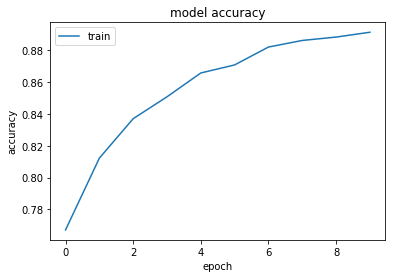

In [21]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
batch_size = 1
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=False)
y_pred = CNN_model.predict_generator(test_generator, test_examples//batch_size, workers=4)
# model.predict_classes(test_x)
# np.count_nonzero(y_pred == test_y)/len(test_y)

Found 2899 images belonging to 2 classes.


In [23]:
correct = 0
true_correct = 0
for i, f in enumerate(test_generator.filenames):
    if f.startswith('negative') and y_pred[i]<0.5:
        correct +=1
    if f.startswith('positive') and y_pred[i]>=0.5:
        correct +=1

print('Correct predictions: '+str(correct/len(test_generator.filenames)))

Correct predictions: 0.8720248361503967


In [25]:
batch_size = 6
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True)
x_test, y_test = next(test_generator)

p = CNN_model.predict(x_test)
label_dict = {0: 'negative', 1: 'positive'}

Found 2899 images belonging to 2 classes.


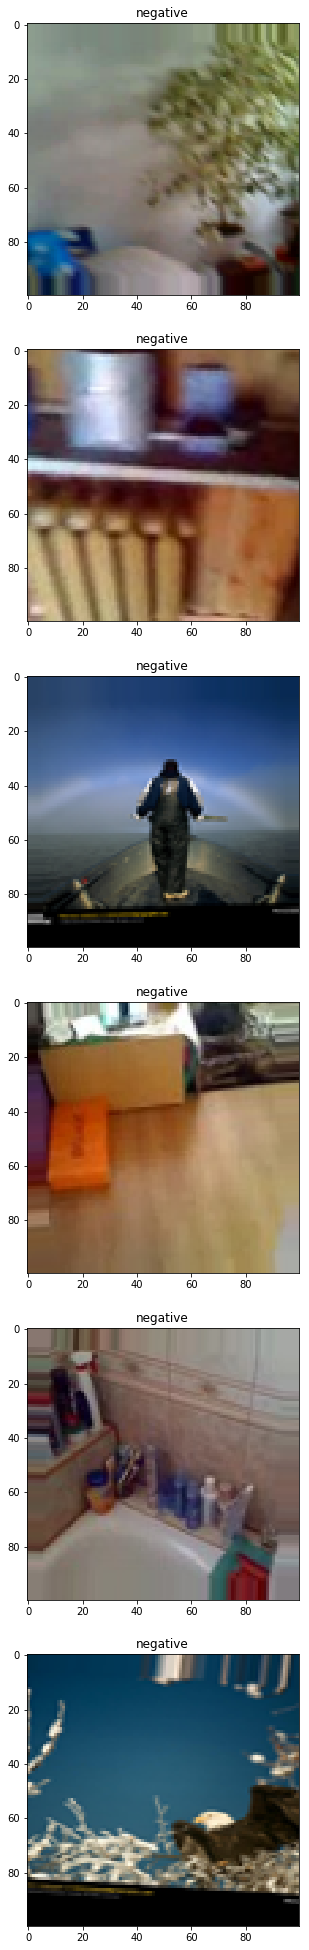

In [26]:
plt.figure(figsize=(35,35))

for i in range(batch_size):
    plt.subplot(batch_size,2,2*i+1)
    plt.imshow(x_test[i])
    plt.title(label_dict[y_test[i]])

plt.show()

In [48]:
image = get_image()
cv2.imwrite('test.png', image)

img = Image.open('test.png')

img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255

r = CNN_model.predict(np.array([img]))

This is a knife
Confidence:  0.8787047


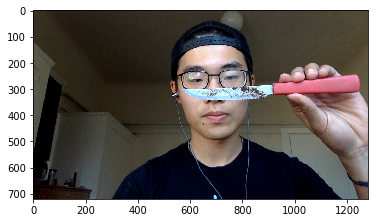

In [49]:
plt.imshow(Image.open('test.png'))
if r[0][0] < 0.5:
    print("This is not a knife")
    print("Confidence: ", 1 - r[0][0])
    
else:
    print("This is a knife")
    print("Confidence: ", r[0][0])

### Transfer Learning (VGG-16)

In [71]:
from keras import applications

datagen = ImageDataGenerator(rescale=1.0/255)
VGG_model = applications.VGG16(include_top=False, input_shape=(img_width, img_height, channels))

In [184]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
#bottleneck_features_train = VGG_model.predict_generator(generator, train_examples//batch_size, verbose=1, workers=4)
#pickle.dump(bottleneck_features_train, open('bottleneck_features_train.npy', 'wb'))
#bottleneck_features_train.shape

Found 10000 images belonging to 2 classes.


In [185]:
batch_size = 128
valid_generator = datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
#bottleneck_features_valid = VGG_model.predict_generator(generator, test_examples//batch_size, verbose=1, workers=4)
#with open('bottleneck_features_valid.npy', 'wb') as f:
#    pickle.dump(bottleneck_features_valid, f)
#bottleneck_features_valid.shape

Found 2899 images belonging to 2 classes.


In [186]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

VGG_model = Sequential()
VGG_model.add(Flatten(input_shape = bottleneck_features_train.shape[1:]))
VGG_model.add(Dense(256, activation='relu'))
VGG_model.add(Dropout(0.5))
VGG_model.add(Dense(1, activation='sigmoid'))

VGG_model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
VGG_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 1,180,161
Trainable params: 1,180,161
Non-trainable params: 0
_________________________________________________________________


In [187]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

labels = np.array([0 if f.startswith('negative') else 1 for f in generator.filenames])[:len(bottleneck_features_train)]
VGG_history = VGG_model.fit(bottleneck_features_train, labels, epochs=10, batch_size=batch_size)

Found 10000 images belonging to 2 classes.
Epoch 1/10
9984/9984 [==============================] - 3s 346us/step - loss: 0.4904 - acc: 0.8258
Epoch 2/10
9984/9984 [==============================] - 3s 289us/step - loss: 0.2528 - acc: 0.8905
Epoch 3/10
9984/9984 [==============================] - 3s 287us/step - loss: 0.2085 - acc: 0.9140
Epoch 4/10
9984/9984 [==============================] - 3s 272us/step - loss: 0.1723 - acc: 0.9252
Epoch 5/10
9984/9984 [==============================] - 3s 317us/step - loss: 0.1607 - acc: 0.9344
Epoch 6/10
9984/9984 [==============================] - 3s 269us/step - loss: 0.1422 - acc: 0.9425
Epoch 7/10
9984/9984 [==============================] - 3s 261us/step - loss: 0.1197 - acc: 0.9561
Epoch 8/10
9984/9984 [==============================] - 3s 271us/step - loss: 0.1104 - acc: 0.9569
Epoch 9/10
9984/9984 [==============================] - 3s 273us/step - loss: 0.0939 - acc: 0.9637
Epoch 10/10
9984/9984 [==============================] - 4s 388us/

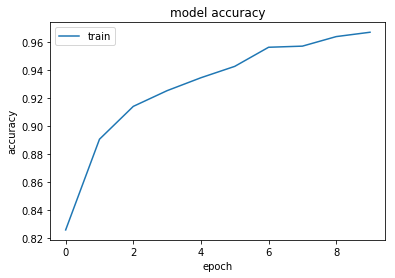

In [188]:
plt.plot(VGG_history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [189]:
with open('bottleneck_features_valid.npy','rb') as f:
    bottleneck_features_valid = pickle.load(f)
    
valid_labels = np.array([0 if f.startswith('negative') else 1 for f in valid_generator.filenames])[:len(bottleneck_features_valid)]
y_valid_pred = VGG_model.predict_classes(bottleneck_features_valid)
accuracy = np.count_nonzero(valid_labels == y_valid_pred.ravel())/len(valid_labels)

print('\nThe accuracy is: '+str(accuracy))


The accuracy is: 0.7574573863636364


In [190]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, channels))
combinedModel = Model(inputs= vgg16.input, outputs= VGG_model(vgg16.output))

for layer in combinedModel.layers[:-3]:
    layer.trainable = False

In [191]:
combinedModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

### Fine-tuning (This may take one to two hours)

In [101]:
VGG_model.save_weights('fc_model.h5')

In [102]:
combinedModel.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4, decay=0.9), # optimizers.SGD(lr=1e-4, momentum=0.9)
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2899 images belonging to 2 classes.


In [103]:
# fine-tune the model
combinedModel.fit_generator(
    train_generator,
    steps_per_epoch=train_examples//batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=test_examples//batch_size) # len(valid_generator.filenames)

Epoch 1/5
78/78 [==============================] - 2334s 30s/step - loss: 1.2813 - acc: 0.4110 - val_loss: 1.0321 - val_acc: 0.4677
Epoch 2/5
78/78 [==============================] - 4183s 54s/step - loss: 0.8882 - acc: 0.5181 - val_loss: 0.9145 - val_acc: 0.5075
Epoch 3/5
78/78 [==============================] - 1626s 21s/step - loss: 0.8141 - acc: 0.5469 - val_loss: 0.8591 - val_acc: 0.5359
Epoch 4/5
78/78 [==============================] - 1796s 23s/step - loss: 0.7804 - acc: 0.5663 - val_loss: 0.8250 - val_acc: 0.5547
Epoch 5/5
78/78 [==============================] - 1873s 24s/step - loss: 0.7629 - acc: 0.5818 - val_loss: 0.8007 - val_acc: 0.5678


In [199]:
image = get_image()
cv2.imwrite('test.png', image)

True

In [200]:
img = Image.open('test.png')
input_shape = (3,3)

img_resized = img.resize(input_shape, Image.ANTIALIAS)

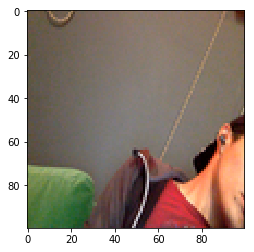

This is a knife
Confidence:  0.97202975


In [201]:
img = Image.open('test.png')
img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255
plt.imshow(img)
plt.show()
p = combinedModel.predict(np.array([img]))
if p[0][0] < 0.5:
    print("This is not a knife")
    print("Confidence: ", 1-p[0][0])
else:
    print("This is a knife")
    print("Confidence: ", p[0][0])

In [5]:
path = "/anaconda3/lib/python3.6/site-packages/cv2/data/"
cam = cv2.VideoCapture(0)
detector=cv2.CascadeClassifier(path + 'haarcascade_frontalface_default.xml')

In [ ]:
while(True):
    ret, img = cam.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    cv2.imshow('frame',img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break